A simple GAN.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras.models import Model
from scipy.ndimage import gaussian_filter
import time
from IPython import display

(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

(mn_x_train, _), (mn_x_test, _) = mnist.load_data()
mn_x_train = mn_x_train.astype('float32') / 255.
mn_x_test = mn_x_test.astype('float32') / 255.

mn_x_train = mn_x_train[..., tf.newaxis]
mn_x_test = mn_x_test[..., tf.newaxis]

print(x_train.shape)

2023-10-04 03:00:28.272121: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-04 03:00:28.368541: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-04 03:00:28.652061: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-04 03:00:28.652124: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-04 03:00:28.653557: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

11490434/11490434 [==============================] - 1s 0us/step
(60000, 28, 28, 1)


In [2]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

class GAN(tf.keras.Model):
    """Generative Adversarial Network."""

    def __init__(self, gen_input_dim=100):
        super(GAN, self).__init__()
        self.gen_input_dim = gen_input_dim
        self.generator = tf.keras.Sequential(
            [
                layers.InputLayer(input_shape=(gen_input_dim,)),
                layers.Dense(7 * 7 * 256),
                layers.BatchNormalization(),
                layers.ReLU(),
                layers.Reshape((7, 7, 256)),
                layers.Conv2DTranspose(128, 5, strides=1, padding='same'),
                layers.BatchNormalization(),
                layers.ReLU(),
                layers.Conv2DTranspose(64, 5, strides=2, padding='same'),
                layers.BatchNormalization(),
                layers.ReLU(),
                layers.Conv2DTranspose(1, 5, strides=2, padding='same', activation='sigmoid')
            ]
        )

        self.discriminator = tf.keras.Sequential(
            [
                layers.Conv2D(64, 5, strides=2, padding='same', input_shape=[28, 28, 1]),
                layers.ReLU(),
                layers.Dropout(0.3),
                layers.Conv2D(128, 5, strides=2, padding='same'),
                layers.ReLU(),
                layers.Dropout(0.3),
                layers.Flatten(),
                layers.Dense(1)
            ]
        )

        @tf.function
        def sample(self, eps=None):
            if eps is None:
                eps = tf.random.normal(shape=(100, self.latent_dim))
            return self.generator(eps, training=False)


class GAN_trainer():
    def __init__(self, train_images, gen_input_dim=100, batch_size=256):
        self.gan = GAN(gen_input_dim)
        self.generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.gen_input_dim = gen_input_dim
        self.num_examples_to_generate = 16
        self.seed = tf.random.normal([self.num_examples_to_generate, self.gen_input_dim])
        self.batch_size = batch_size
        self.dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_images.shape[0]).batch(
            self.batch_size)
        self.num_batches = train_images.shape[0] // self.batch_size

    def discriminator_loss(self, real_labels, fake_labels):
        """
        Computes the loss function for the discriminator.

        :param real_labels: labels from the discriminator from the real images. I.e. What the discriminator believes the real images are
        :param fake_labels: labels from the discriminator from the generated images. I.e. What the discriminator believes the generated images are
        :return: the computed discriminator loss
        """
        real_loss = cross_entropy(tf.ones_like(real_labels), real_labels)
        fake_loss = cross_entropy(tf.zeros_like(fake_labels), fake_labels)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, discriminator_labels, generator_labels=None):
        """
        Computes the loss function for the generator.

        Takes in the output of the descriminator from the generated images.

        :param discriminator_labels: output from the descriminator, I.e. what the discriminator believes the images were.
        :param generator_labels: what the generator wants the images to be labeled as
        :return: the cross entropy loss between the estimated labels and the target labels
        """
        if generator_labels is None:
            # Does the default as from class, just trying to produce valid images, not necessarily with a label attached
            generator_labels = tf.ones_like(discriminator_labels)
        return cross_entropy(generator_labels, discriminator_labels)

    @tf.function
    def train_step(self, images):
        """
        Completes a training step

        :param images: images to train on
        :return: generator loss and discriminator loss
        """
        generator_noise = tf.random.normal([self.batch_size, self.gen_input_dim])

        # For odd and even numbers
        generator_labels = tf.ones_like(generator_noise)

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.gan.generator(generator_noise, training=True)

            real_output = self.gan.discriminator(images, training=True)
            descriminator_output = self.gan.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(descriminator_output)
            disc_loss = self.discriminator_loss(real_output, descriminator_output)

            gradients_of_generator = gen_tape.gradient(gen_loss, self.gan.generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, self.gan.discriminator.trainable_variables)

            self.generator_optimizer.apply_gradients(
                zip(gradients_of_generator, self.gan.generator.trainable_variables))
            self.discriminator_optimizer.apply_gradients(
                zip(gradients_of_discriminator, self.gan.discriminator.trainable_variables))
        return gen_loss, disc_loss

    @staticmethod
    def random_one_hot_matrix(num_rows, num_cols):
        """
        Creates a random one hot matrix

        :param num_rows: number of rows in the matrix
        :param num_cols: number of columns in the matrix
        :return: a random one hot matrix
        """
        return tf.one_hot(tf.random.uniform(shape=(num_rows,), minval=0, maxval=num_cols, dtype=tf.int32), num_cols)

    def train(self, epochs):
        self.gen_losses = []
        self.disc_losses = []
        for epoch in range(epochs):
            start = time.time()

            gen_loss = 0
            disc_loss = 0
            for image_batch in self.dataset:
                gl, dl = self.train_step(image_batch)
                gen_loss += gl
                disc_loss += dl

            self.gen_losses.append(gen_loss / self.num_batches)
            self.disc_losses.append(disc_loss / self.num_batches)

            # Produce images for the GIF as we go
            display.clear_output(wait=True)
            print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

            self.generate_and_save_images(epoch)

        # Generate after the final epoch
        display.clear_output(wait=True)
        self.generate_and_save_images(epochs)

    def generate_and_save_images(self, epoch):
        predictions = self.gan.generator(self.seed, training=False)

        fig = plt.figure(figsize=(4, 4))
        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow(predictions[i, :, :, 0], cmap='gray')

        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()

        fig, ax1 = plt.subplots(1, 1, sharey=True, figsize=(10, 5))
        ax1.plot(self.gen_losses, label='Generator Loss')
        ax1.plot(self.disc_losses, label='Discriminator Loss')
        ax1.legend()
        plt.show()#%% md


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras.models import Model
from scipy.ndimage import gaussian_filter
# import time
from IPython import display

(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

(mn_x_train, _), (mn_x_test, _) = mnist.load_data()
mn_x_train = mn_x_train.astype('float32') / 255.
mn_x_test = mn_x_test.astype('float32') / 255.

mn_x_train = mn_x_train[..., tf.newaxis]
mn_x_test = mn_x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


In [4]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


class GAN(tf.keras.Model):
    """Generative Adversarial Network."""

    def __init__(self, gen_input_dim=100):
        super(GAN, self).__init__()
        self.gen_input_dim = gen_input_dim
        self.generator = tf.keras.Sequential(
            [
                layers.InputLayer(input_shape=(gen_input_dim,)),
                layers.Dense(7 * 7 * 256),
                layers.BatchNormalization(),
                layers.ReLU(),
                layers.Reshape((7, 7, 256)),
                layers.Conv2DTranspose(128, 5, strides=1, padding='same'),
                layers.BatchNormalization(),
                layers.ReLU(),
                layers.Conv2DTranspose(64, 5, strides=2, padding='same'),
                layers.BatchNormalization(),
                layers.ReLU(),
                layers.Conv2DTranspose(1, 5, strides=2, padding='same', activation='sigmoid')
            ]
        )

        self.discriminator = tf.keras.Sequential(
            [
                layers.Conv2D(64, 5, strides=2, padding='same', input_shape=[28, 28, 1]),
                layers.ReLU(),
                layers.Dropout(0.3),
                layers.Conv2D(128, 5, strides=2, padding='same'),
                layers.ReLU(),
                layers.Dropout(0.3),
                layers.Flatten(),
                layers.Dense(1)
            ]
        )

        @tf.function
        def sample(self, eps=None):
            if eps is None:
                eps = tf.random.normal(shape=(100, self.latent_dim))
            return self.generator(eps, training=False)


class GAN_trainer():
    def __init__(self, train_images, gen_input_dim=100, batch_size=256):
        self.gan = GAN(gen_input_dim)
        self.generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.gen_input_dim = gen_input_dim
        self.num_examples_to_generate = 16
        self.seed = tf.random.normal([self.num_examples_to_generate, self.gen_input_dim])
        self.batch_size = batch_size
        self.dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_images.shape[0]).batch(
            self.batch_size)
        self.num_batches = train_images.shape[0] // self.batch_size

    def discriminator_loss(self, real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, estimated_labels, target_labels=None):
        """
        Computes the loss function for the generator.

        Takes in the output of the descriminator from the generated images.

        :param estimated_labels: output from generated images
        :return:
        """
        if target_labels is None:
            # Does the default as from class, just trying to produce valid images, not necessarily with a label attached
            target_labels = tf.ones_like(estimated_labels)

        return cross_entropy(tf.ones_like(estimated_labels), estimated_labels)

    @tf.function
    def train_step(self, images):
        noise = tf.random.normal([self.batch_size, self.gen_input_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.gan.generator(noise, training=True)

            real_output = self.gan.discriminator(images, training=True)
            descriminator_output = self.gan.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(descriminator_output)
            disc_loss = self.discriminator_loss(real_output, descriminator_output)

            gradients_of_generator = gen_tape.gradient(gen_loss, self.gan.generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, self.gan.discriminator.trainable_variables)

            self.generator_optimizer.apply_gradients(
                zip(gradients_of_generator, self.gan.generator.trainable_variables))
            self.discriminator_optimizer.apply_gradients(
                zip(gradients_of_discriminator, self.gan.discriminator.trainable_variables))
        return gen_loss, disc_loss

    def train(self, epochs):
        self.gen_losses = []
        self.disc_losses = []
        for epoch in range(epochs):
            start = time.time()

            gen_loss = 0
            disc_loss = 0
            for image_batch in self.dataset:
                gl, dl = self.train_step(image_batch)
                gen_loss += gl
                disc_loss += dl

            self.gen_losses.append(gen_loss / self.num_batches)
            self.disc_losses.append(disc_loss / self.num_batches)

            # Produce images for the GIF as we go
            display.clear_output(wait=True)
            print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

            self.generate_and_save_images(epoch)

        # Generate after the final epoch
        display.clear_output(wait=True)
        self.generate_and_save_images(epochs)

    def generate_and_save_images(self, epoch):
        predictions = self.gan.generator(self.seed, training=False)

        fig = plt.figure(figsize=(4, 4))
        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow(predictions[i, :, :, 0], cmap='gray')

        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()

        fig, ax1 = plt.subplots(1, 1, sharey=True, figsize=(10, 5))
        ax1.plot(self.gen_losses, label='Generator Loss')
        ax1.plot(self.disc_losses, label='Discriminator Loss')
        ax1.legend()
        plt.show()


In [5]:
gan = GAN_trainer(mn_x_train)
gan.train(epochs=50)

KeyboardInterrupt: 

Time for epoch 6 is 7.656101226806641 sec


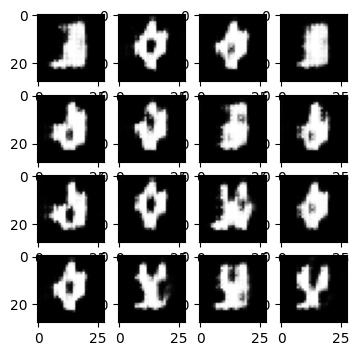

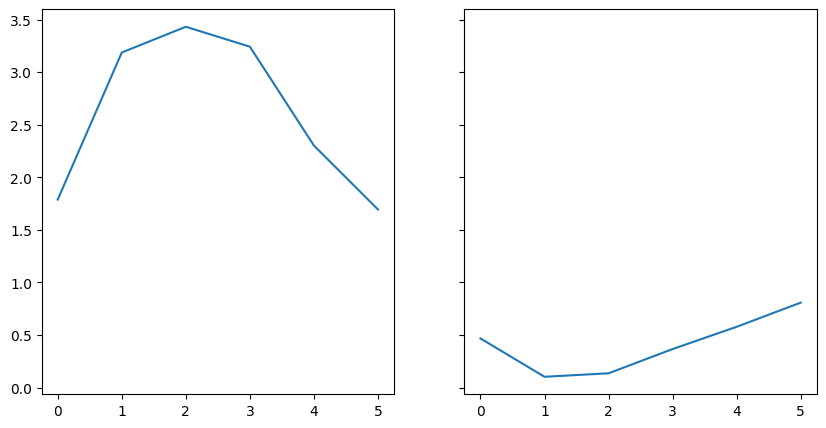

KeyboardInterrupt: 

In [29]:
gan = GAN_trainer(mn_x_train)
gan.train(epochs=50)